In [25]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from tqdm import tqdm 
from sklearn.metrics import confusion_matrix
import seaborn as sns
#from Pytorchtools import EarlyStopping
from sklearn.model_selection import KFold
import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.pruners import PercentilePruner
import pytorch_lightning as pl
from torch.nn import functional as F
from sklearn.model_selection import KFold
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

SAMPLE AT INDEX 0
LABEL: 9


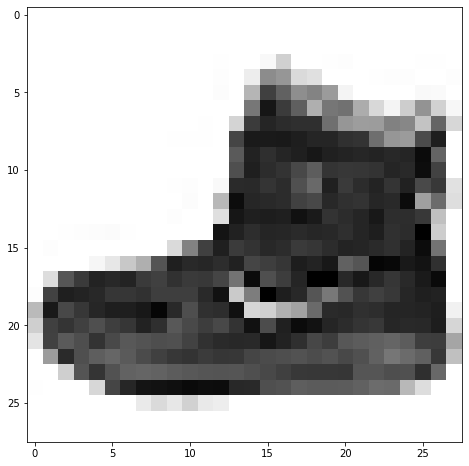

In [4]:
sample_index = 0
image = train_dataset[sample_index][0]
label = train_dataset[sample_index][1]

fig = plt.figure(figsize=(8,8))
plt.imshow(image, cmap='Greys')
print(f"SAMPLE AT INDEX {sample_index}")
print(f"LABEL: {label}")

In [5]:
image_numpy = np.array(image)

print(f'Numpy array shape: {image_numpy.shape}')
print(f'Numpy array type: {image_numpy.dtype}')

Numpy array shape: (28, 28)
Numpy array type: uint8


In [6]:
to_tensor = torchvision.transforms.ToTensor()
image_tensor = to_tensor(image)

print(f'PyTorch tensor shape: {image_tensor.shape}')
print(f'PyTorch tensor type: {image_tensor.dtype}')

PyTorch tensor shape: torch.Size([1, 28, 28])
PyTorch tensor type: torch.float32


## Classification Model 

- Data Augmentation or modification to avoid overfitting and better generalization
- Create training/validation/test and load into Pytorch
- In this case this cells have been runned with the already calculated near to optimal paramaters

In [3]:
train_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.RandomHorizontalFlip(p=0.1),
  transforms.Normalize((0.1307,), (0.3081,)),
  # transforms.RandomRotation(degrees=(0, 180)),]), p=0.1),
  transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0))]), p=0.3)
])

test_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))
  #transforms.RandomVerticalFlip(p=0.1)
])

In [67]:
train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True,
                                                  download=True, transform=train_transform)

test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False,
                                                  download=True, transform=test_transform)

In [5]:
train_size = int(0.8 * len(train_dataset)) #80% for the training 20% for the validation
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [6]:
print('Train size:',len(train_dataset))
print('Val size:',len(val_dataset))
print('Test size:',len(test_dataset))

Train size: 48000
Val size: 12000
Test size: 10000


In [7]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Defining the Architecture

In [8]:
class Network(nn.Module):
    def __init__(self, n_channels = 1 , dropout = 0.):
        '''
        - 1 Convolutional layer + stride
        - 1 Convolutional layer + stride
        - Flattening
        - 1 Dense layer + Dropout 
        - 1 Dense layer (10 units) -> OUTPUT
        ======================================================
        INPUT
         - drop (float)    : probability of dropout for the two dense layers
         - n_channels(int) : number of output channels of the first layer
        ======================================================
        '''
        super().__init__()

        self.batch_size = n_channels
        flatten_dim = (2*n_channels)*5*5

        #Network architecture related code
        #in order to reduce halve the dimensionality, the stride parameter is 2
        # ---> img size 28x28 -> 14x14
        self.conv1 = nn.Conv2d(in_channels = 1,  out_channels = n_channels, kernel_size = 4, padding=1, stride = 2)
        #self.batch1 = nn.BathNorm2d()
        self.conv2 = nn.Conv2d(in_channels = n_channels, out_channels = 2*n_channels, kernel_size=5, stride = 2)
        #self.batch2 = nn.BathNorm2d()

        #fully connected layers
        self.fc1 = nn.Linear(flatten_dim, 128)
        self.out = nn.Linear(128, 10)
        
        #Activation function related code 
        self.relu  = nn.ReLU()

        #Dropout related code
        self.drop = nn.Dropout(p = dropout)
        
        #print("Network initialized!")


    def forward(self, x, additional_out=False):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.drop(self.fc1(x)))
        x = self.out(x)

        return x

    def train_epoch(self, train_dataloader, loss_function, optimizer, device):
        '''
        Train the network (self) using as input eventual batches from train_data_loader,
        having chosen the loss_function and the optimizer
        it returns:
        - the mean loss over batches
        - the standard deviation loss over batches
        '''
        #enable training mode
        self.train()
        ### TRAIN
        train_loss = []
        for i_batch, sample_batched in enumerate(train_dataloader):

            #divide the batch into values and labels
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)

            #Forward pass
            out = self.forward(x_batch)

            # Compute loss
            loss = loss_function(out, label_batch)

            # Backpropagation
            self.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
            

        # Save average train loss
        train_loss_mean = np.mean(train_loss)
        train_loss_std  = np.std(train_loss)
        

        return train_loss_mean, train_loss_std
    
    def val_epoch(self, val_dataloader, loss_function, optimizer, device):
        '''
        Evaulate the performance of network (self)
        using as input the validation set,
        having chosen the loss_function and the optimizer
        it returns:
        - the mean loss over batches
        - the standard deviation loss over batches
        '''
        #enable training mode
        self.eval()
        val_loss = []
        
        with torch.no_grad(): # Disable gradient tracking
            for i_batch, sample_batched in enumerate(val_dataloader):
                #divide the batch into values and labels
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                #Forward pass
                out = self.forward(x_batch)
                
                #No backpropagation for validation

                # Compute loss
                loss = loss_function(out, label_batch)
                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)

        # Save average val loss
        val_loss_mean = np.mean(val_loss)
        val_loss_std  = np.std(val_loss)

        return val_loss_mean, val_loss_std

    def test(self, test_dataloader, params_dict):
        '''
        Test the network in a classification task
        '''
        wrong_label = 0
        predictions = []
        true_labels = []

        self.eval()
        device = params_dict.get('device')
        # Disable gradient tracking
        with torch.no_grad():
            for sample_batched in test_dataloader:
                #divide the batch into values and labels
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)

                #Forward pass
                out = self.forward(x_batch)
                out = out.cpu().numpy().argmax()

                predictions.append(out)
                true_labels.append(label_batch)
                
        num_samples = len(test_dataloader)
        temp_list = [predictions[i]-true_labels[i] for i in range(num_samples)]
        #"zero" elements are the correct ones
        accuracy = temp_list.count(0)/num_samples
        return accuracy
    
    def predict(self,data_input, device):
        '''
        Compute an array of predicted labels given input data
        '''
        #set evaluation mode
        self.eval()
        predictions_list = []

        #disable gradient computing/tracking
        with torch.no_grad():
            for i_batch, sample_batched in enumerate(data_input):
                x_batch = sample_batched[0].to(device) 
                #Forward pass
                out = self.forward(x_batch)
                outputs = out.cpu().numpy().argmax()

                predictions_list.append(outputs)
        return np.array(predictions_list)
    
        #save the network state onto a path passed as input
    def save_net(self, path: str):
        torch.save( self.state_dict(), path )
    
    #retrieve the network state from a path passed as input
    def load_net(self, path: str):
        self.load_state_dict( torch.load(path) )
        
    def fit(self, train_data, val_data, params_dict, loss_fn, plot = False):
        train_loss_means = []
        val_loss_means = []

        train_loss_std = []
        val_loss_std = []

        optimizer = params_dict.get('optimizer')
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        device = params_dict.get('device')

        for epoch in tqdm(range(params_dict.get('n_epochs'))):
            loss_mean, loss_std =  self.train_epoch(train_data, loss_fn, optimizer, device)
            train_loss_means.append(loss_mean)
            train_loss_std.append(loss_std)

            loss_mean, loss_std =  self.val_epoch(val_data, loss_fn, optimizer, device)
            val_loss_means.append(loss_mean)
            val_loss_std.append(loss_std)
            
            scheduler.step() #updating the learning rate

        train_metrics = np.array([np.array(train_loss_means), np.array(train_loss_std)])
        val_metrics = np.array([np.array(val_loss_means), np.array(val_loss_std)])

        if (plot): #plots the results
            plt.figure(figsize = (8,6))
            plt.plot(train_metrics[0,:], label = 'train')
            plt.plot(val_metrics[0,:], label = 'test')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.title('Loss vs epochs')
            plt.grid('on')
            plt.legend(loc=1,prop={'size': 12})
            plt.show()

        return train_metrics, val_metrics

In [9]:
model = Network(8,0.004).to(device)
print(model)

Network(
  (conv1): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.004, inplace=False)
)


Define Loss and optimizer

In [10]:
fit_dict = {'device': device, 
            'optimizer': optim.Adam(model.parameters(),lr=0.002, weight_decay=0.0045) ,
            'n_epochs': 60,
            'device': 'cpu'
            }

loss_function = nn.CrossEntropyLoss()

In [306]:
model.fit(train_data = train_dataloader,
          val_data = val_dataloader,
          params_dict = fit_dict,
          loss_fn = loss_function,
          plot = True)



  0%|                                                                                           | 0/60 [00:00<?, ?it/s]

  2%|█▍                                                                                 | 1/60 [00:33<32:48, 33.37s/it]

  3%|██▊                                                                                | 2/60 [01:01<30:41, 31.74s/it]

  5%|████▏                                                                              | 3/60 [01:28<28:49, 30.34s/it]

  7%|█████▌                                                                             | 4/60 [01:57<28:01, 30.03s/it]

  8%|██████▉                                                                            | 5/60 [02:28<27:50, 30.38s/it]

 10%|████████▎                                                                          | 6/60 [02:57<26:50, 29.83s/it]

 12%|█████████▋                                                                         | 7/60 [03:29<26:49, 30.36s/it]

 13%|███████████              

KeyboardInterrupt: 

In [252]:
torch.save(model.state_dict(), 'classification_opt.pt')

In [11]:
model = Network(16,0.004).to(device)
model.load_state_dict(torch.load('classification_16.pt',map_location=torch.device('cpu')))
model.eval()

Network(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.004, inplace=False)
)

## Accuracy results

In [17]:
####### NO OPtimization ###########

print("Simple model without optimization accuracy is: ", model.test( test_dataloader, fit_dict ))

Simple model without optimization accuracy is:  0.8463


In [12]:
####### YES OPtimization ###########

print("Simple model without optimization accuracy is: ", model.test( test_dataloader, fit_dict ))

Simple model without optimization accuracy is:  0.8866



 Confusion matrix (normalized)


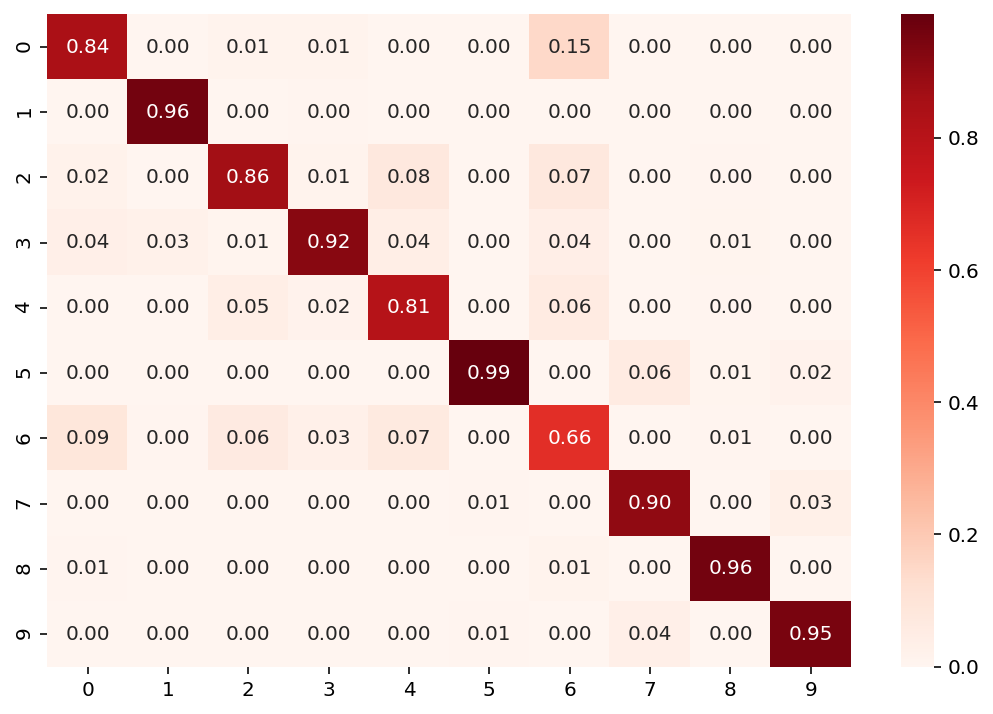

In [13]:
y_pred = model.predict(test_dataloader,fit_dict.get('device'))
y_true = np.array([x[1] for x in test_dataset])

unique, counts = np.unique(y_true, return_counts=True)
matrix = confusion_matrix( y_pred, y_true)


print("\n Confusion matrix (normalized)")
plt.figure(figsize = (9,6))
sns.heatmap(matrix/counts[:,None], annot=True, fmt =  "1.2f" , cmap="Reds" )
plt.show()

#### Incorrect predictions

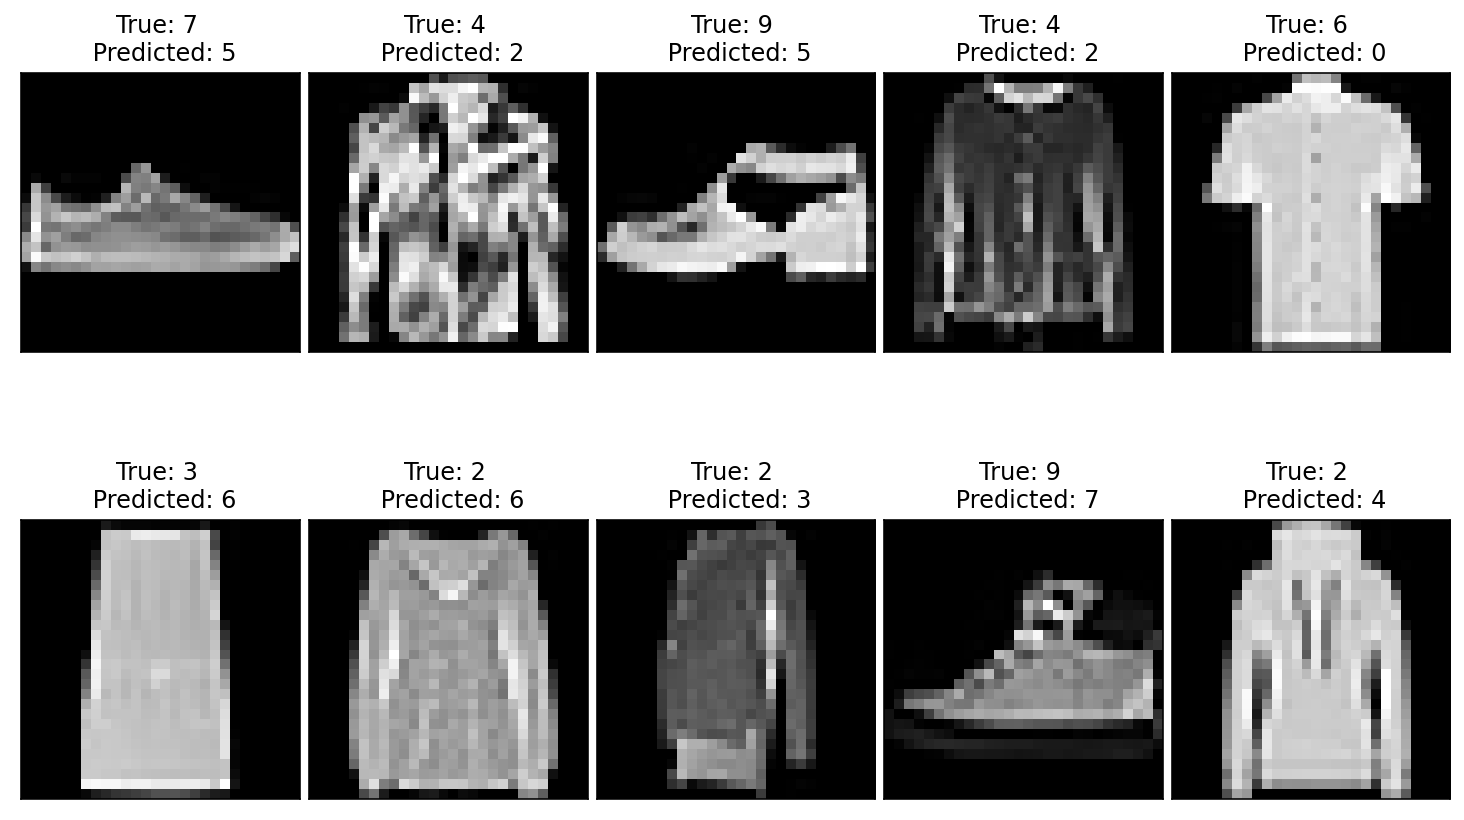

In [14]:
error = np.where(y_pred != y_true)[0]
error = error[0:10]

fig = plt.figure(figsize = (10,10))
k=0
for i in error:
    plt.subplot(3,5,k+1,)
    plt.tight_layout()
    plt.imshow(test_dataset[i][0].numpy().transpose(1, 2, 0), cmap='gray', interpolation='none')
    plt.title("True: {} \n Predicted: {}".format(test_dataset[i][1],y_pred[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=.1)
    k+=1

#### Correct predictions

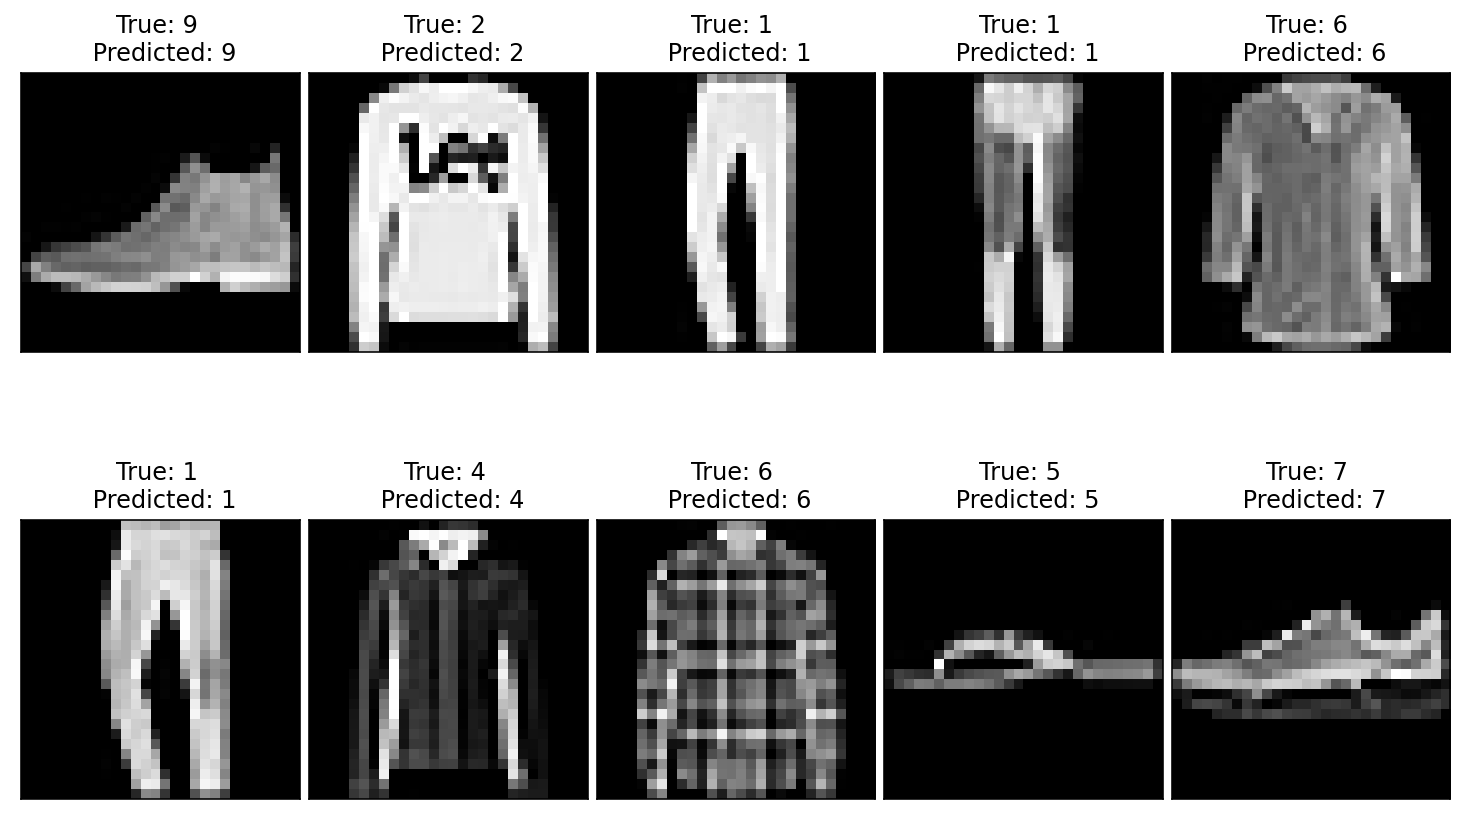

In [15]:
true = np.where(y_pred == y_true)[0]
true = true[0:10]

fig = plt.figure(figsize = (10,10))
k=0
for i in true:
    plt.subplot(3,5,k+1,)
    plt.tight_layout()
    plt.imshow(test_dataset[i][0].numpy().transpose(1, 2, 0), cmap='gray', interpolation='none')
    plt.title("True: {} \n Predicted: {}".format(test_dataset[i][1],y_pred[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout(pad=.1)
    k+=1

## Hyperparameter optimization

In [16]:
def CV_random_set(train_set, valid_set, params_grid, iterations):
    '''
    This functions tries a given number of set of parameters, in order
    to find the optimal set of parameters which reaches the least validation loss
    Since data is few, the search is done after splitting the training data into
    a certain number of folds (K-FOLD cross validation)
    INPUTS:
    - train_set   : training set dataloader
    - valid_set   : validation set dataloader
    - params_grid : a dictionary with the parameters one draws from
    - iterations  : number of set of parameters to test

    OUTPUT:
    A dictionary containing: 
    - the set of parameters chosen
    - training loss for every epoch
    - validation loss for every epoch
    '''

    output_dict = {}
    parameters_list     = []
    train_loss_log      = []
    validation_loss_log = []

    #the loss remains the same due to the nature of the problem
    loss = nn.CrossEntropyLoss()

    for iterat in range(iterations):
        print("\n ################ MODEL", iterat+1, "/", iterations, "  ###########")

        #"draw" a model
        actual_params = sample_set_params(params_grid)
        parameters_list.append(actual_params)

        n_channels = actual_params.get('n_channels')
        drop = actual_params.get('drop')
        optimizer = actual_params.get('optimizer')
        learn_r = actual_params.get('learn_r')
        weight_dec = actual_params.get('weight_dec')
        device = actual_params.get('device')

        #create new network with given parameters and reset weights
        network = Network(n_channels=n_channels, drop=drop).to(device)
        network.apply(reset_weights)

        optimizer = get_correct_optimizer(network, actual_params)

        #instantiate this dummy dict due to "fit" method implementation
        dummy_dict = {'optimizer': optimizer, 'n_epochs': 40, 'device': device}
        #do the job -> training and validation over a single fold
        train_loss, val_loss = network.fit_early_stop(train_set, valid_set, dummy_dict, loss,
                                                      early_stop_flag = True, patience = 2, verbose = False)
                
        #fold is an index that denotes the fold we are dealing with
        train_loss_log.append(train_loss)
        validation_loss_log.append(val_loss)
        clear_output(wait=True)
        del network 


    return  parameters_list, train_loss_log, validation_loss_log 

In [71]:
import torchmetrics

class Network(pl.LightningModule):
    def __init__(self, n_channels, drop):

        super().__init__()
        print('Network initialized')
        self.model = nn.Sequential(
                       nn.Conv2d(in_channels = 1,  out_channels = n_channels, kernel_size = 4, padding=1, stride = 2), 
                       nn.ReLU(), 
                       nn.Conv2d(in_channels = n_channels, out_channels = 2*n_channels, kernel_size=5, stride = 2),
                       nn.ReLU(),
                       nn.Flatten(),
                       nn.Linear(2*n_channels*25, 100),
                       nn.Dropout(p=drop),
                       nn.Linear(100, 10),
                       nn.Softmax(dim=1),
        )
        
        self.val_loss = []
        self.train_loss = []

    # Forward step defines how the LightningModule behaves during inference/prediction.
    def forward(self, x, additional_out=False):
        return self.model(x)

    # Training_step defines the training loop. 
    def training_step(self, batch, batch_idx=None):
        # training_step defines the train loop. It is independent of forward
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.model(x_batch)
        loss = F.cross_entropy(out, label_batch)
        self.train_loss.append(loss)
        self.log("val_loss", loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x_batch = batch[0]
        label_batch = batch[1]
        out = self.model(x_batch)
        loss = F.cross_entropy(out, label_batch)
        self.val_loss.append(loss.item())
        preds = torch.argmax(out, dim=1)
        acc = torchmetrics.functional.accuracy(preds, label_batch)
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss


    def configure_optimizers(self):
        optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        scheduler = {"scheduler":  #scheduler for learning rate
                     torch.optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, patience=2, 
                        threshold=0.00003, 
                        mode='min', verbose=True),
                    "interval": "epoch",
                    "monitor": "val_loss"}
        return [optimizer], [scheduler]


For computational reasons the validation check is been performed $\sim $ 2 times per epoch and the maximal number of epochs has been set to 10.

- This cells has been run on Google Colab

In [72]:
def objective(trial):

    
    # We optimize the number of hidden units in each layer.
    n_channels = trial.suggest_categorical("n_channels", [2, 4, 16, 32])
    drop = trial.suggest_float("dropout", 0., 0.4)   
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])
    lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    weight_norm = trial.suggest_loguniform('weigth_norm',1e-4, 1e0)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_norm)

    
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_dataset)):
    train_loader = create_dataloader(train_dataset.iloc[train_idx])
    valid_loader = create_dataloader(train_dataset.iloc[valid_idx])
    
    
        net = Network(n_channels, drop).to(device)
        early_stop = pl.callbacks.EarlyStopping('val_loss', patience=50)
        trainer = pl.Trainer(gpus=0, max_epochs=10, val_check_interval=200, log_every_n_steps=1,callbacks=[early_stop])
    

        hyperparameters = dict(
                           optimizer=optimizer_name,
                           lr = lr,
                           weight_norm=weight_norm,
                           drop = drop,
                           n_channels = n_channels)
                            
    
        trainer.logger.log_hyperparams(hyperparameters)
        trainer.fit(net, train_dataloader, val_dataloader)

    return trainer.callback_metrics["val_loss"].item()

pruner: optuna.pruners.BasePruner = optuna.pruners.NopPruner()
# print(pruner) <optuna.pruners._nop.NopPruner object at 0x7f4c2466ed50>
# print(type(pruner)) <class 'optuna.pruners._nop.NopPruner'>

This cell has been ran on Colab because of the intesity of the process

In [73]:
study = optuna.create_study(study_name="myfirstoptimizationstudy", direction="minimize", pruner=pruner)
study.optimize(objective, n_trials=2, timeout=300)

[I 2021-11-13 14:04:44,145] A new study created in memory with name: myfirstoptimizationstudy
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 22.0 K
-------------------------------------
22.0 K    Trainable params
0         Non-trainable params
22.0 K    Total params
0.088     Total estimated model params size (MB)


Network initialized


C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\filip\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:110: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


[I 2021-11-13 14:14:46,160] Trial 0 finished with value: 1.5931037664413452 and parameters: {'n_channels': 4, 'dropout': 0.21659922300261672, 'optimizer': 'Adam', 'lr': 0.00013300719670837426, 'weigth_norm': 0.020446406380062204}. Best is trial 0 with value: 1.5931037664413452.


This cell may not be the real best optimal parameters, due to the fact that for computational reasons even on Colab is quite difficult to train this dataset with the optuna library

In [74]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 1
Best trial:
  Value: 1.5931037664413452
  Params: 
    n_channels: 4
    dropout: 0.21659922300261672
    optimizer: Adam
    lr: 0.00013300719670837426
    weigth_norm: 0.020446406380062204


## Inspecting weights & activations

In [34]:
model = Network(n_channels=16, dropout=0.).to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total number of parameters:',count_parameters(model))

Total number of parameters: 116922


In [35]:
model = Network(16,0.004).to(device)
model.load_state_dict(torch.load('classification_16.pt',map_location=torch.device('cpu')))
model.eval()

Network(
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.004, inplace=False)
)

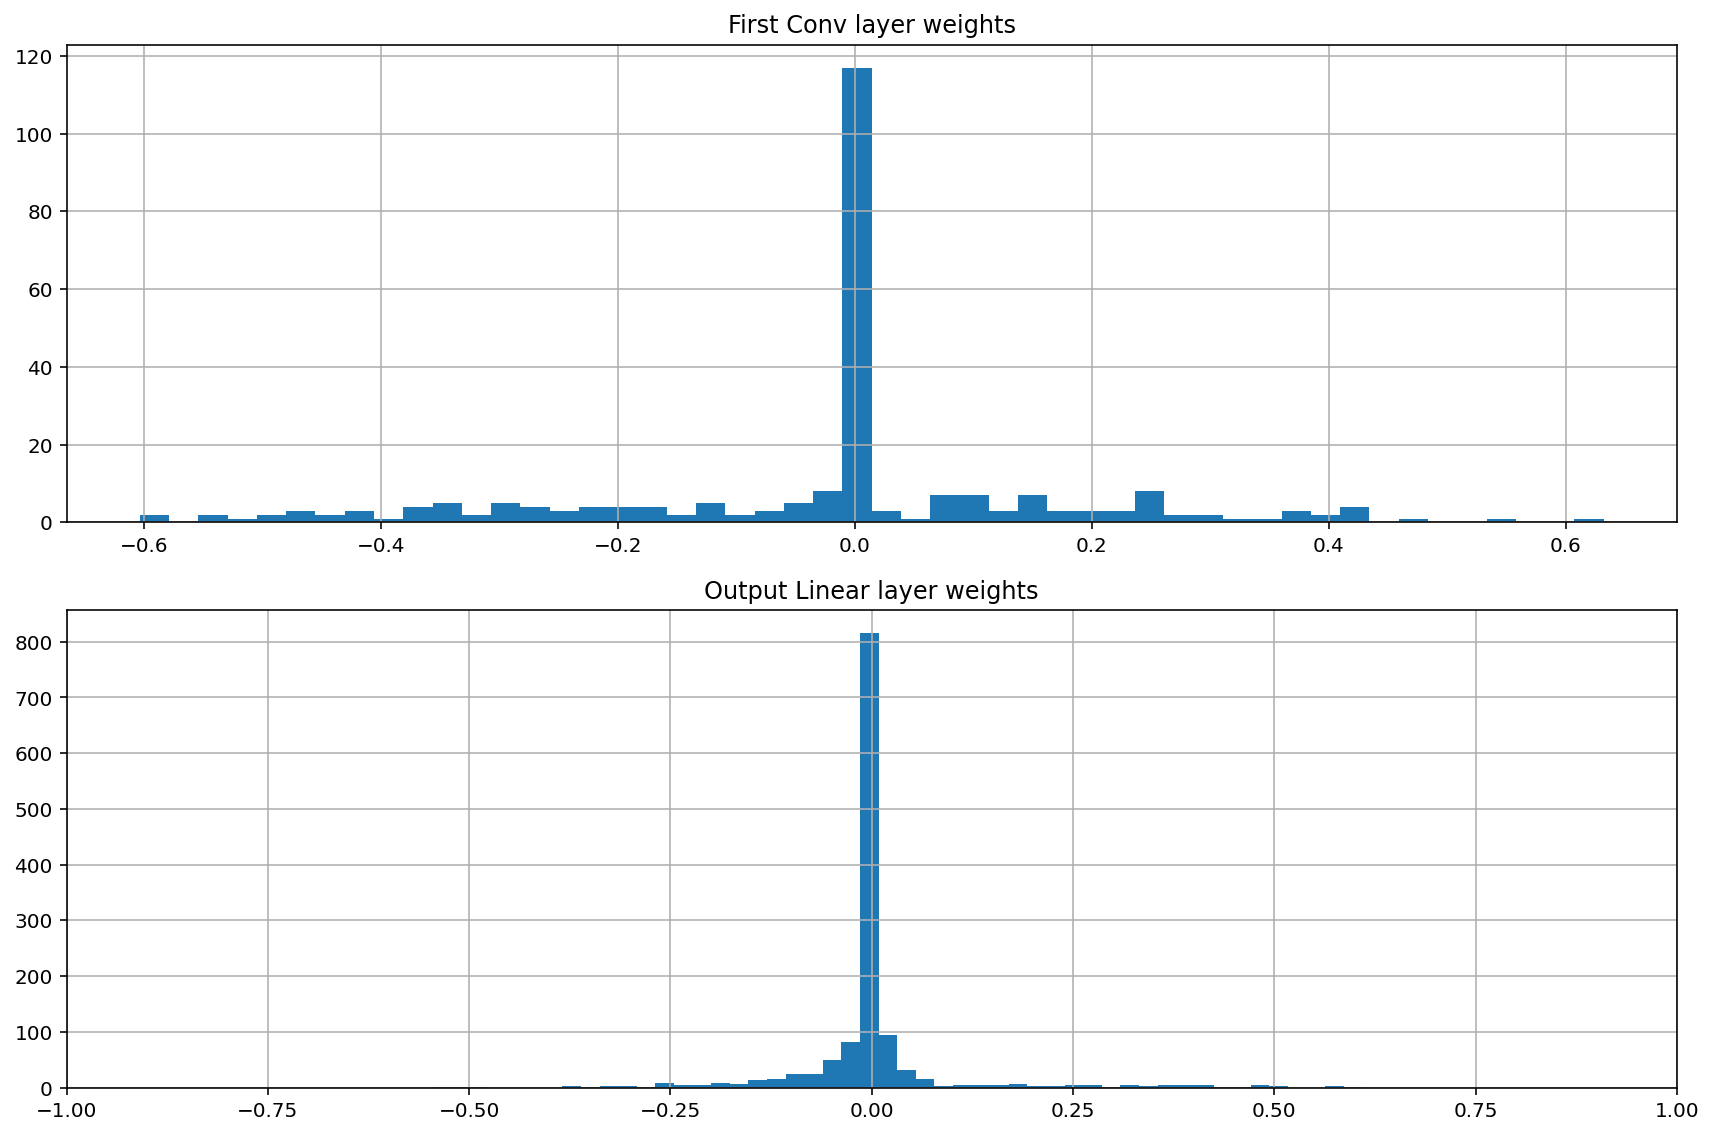

In [47]:
# First hidden layer
h1_w = model.conv1.weight.data.cpu().numpy()
h1_bias   = model.conv1.bias.data.cpu().numpy()

# Second hidden layer
out_w = model.out.weight.data.cpu().numpy()
out_bias   = model.out.bias.data.cpu().numpy()


# Weights histogram
fig, axs = plt.subplots(2, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First Conv layer weights')
axs[1].hist(out_w.flatten(), 50)
axs[1].set_title('Output Linear layer weights')
axs[1].set_xlim([-1, 1])
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In [38]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

In [39]:
# First hidden layer
conv1_weights = model.conv1.weight.data.cpu().numpy()
conv2_weights = model.conv2.weight.data.cpu().numpy()

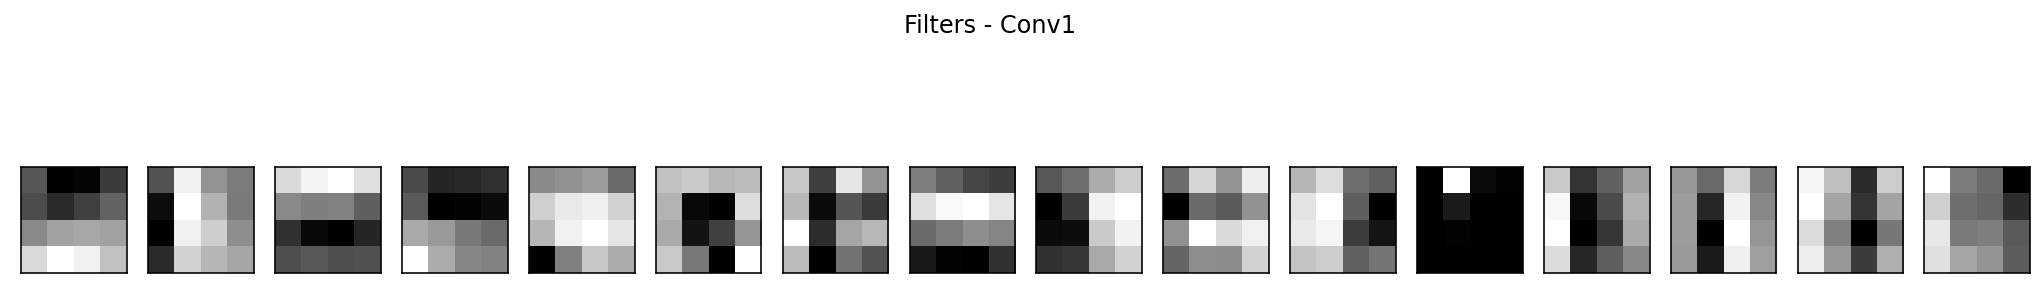

In [40]:
fig, ax = plt.subplots(1,16, figsize=(18, 3))

for i in range(16):
    ax[i].imshow( conv1_weights[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
fig.suptitle('Filters - Conv1 ', fontsize = 12)
plt.savefig('filters_CL1_1.png')
plt.show()

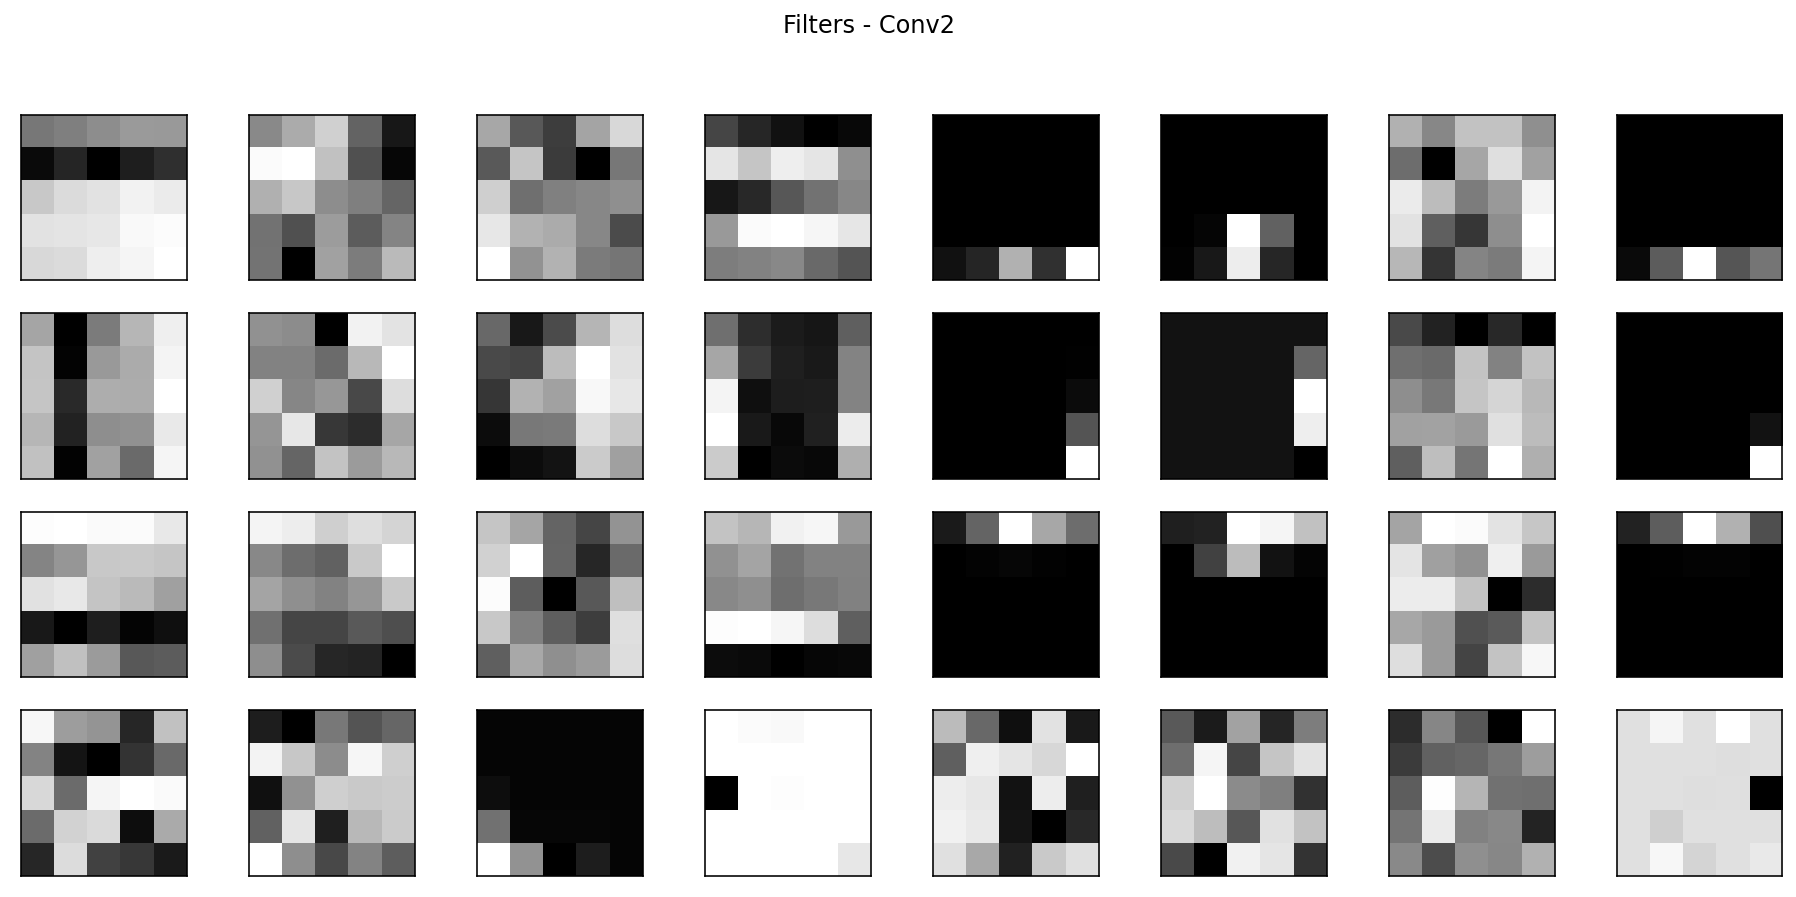

In [41]:
fig, ax = plt.subplots(4, 8, figsize=(16, 7))

for i in range(4):
    for j in range(8):
        ax[i,j].imshow( conv2_weights[j, i, :,:], cmap='Greys')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
    
fig.suptitle('Filters - Conv2 ', fontsize = 12)
plt.savefig('filters_CL1_2.png')
plt.show()

In [42]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output)

In [43]:
### Register hook  
hook_handle1 = model.conv1.register_forward_hook(get_activation)

#load a single image
image_test = torch.utils.data.DataLoader(test_dataset, batch_size = 1, shuffle = True)

### Analyze activations
model.to(device).eval()

with torch.no_grad():
    for s_batch in image_test:
        #save this image to be used later
        my_image = s_batch
        # Move data to device
        x_first = my_image[0].to(device)
        # Forward pass
        y_first = model(x_first)
        z_first = activation
        break

first_conv_layer_act = z_first.cpu().numpy()
### Remove hook
hook_handle1.remove()

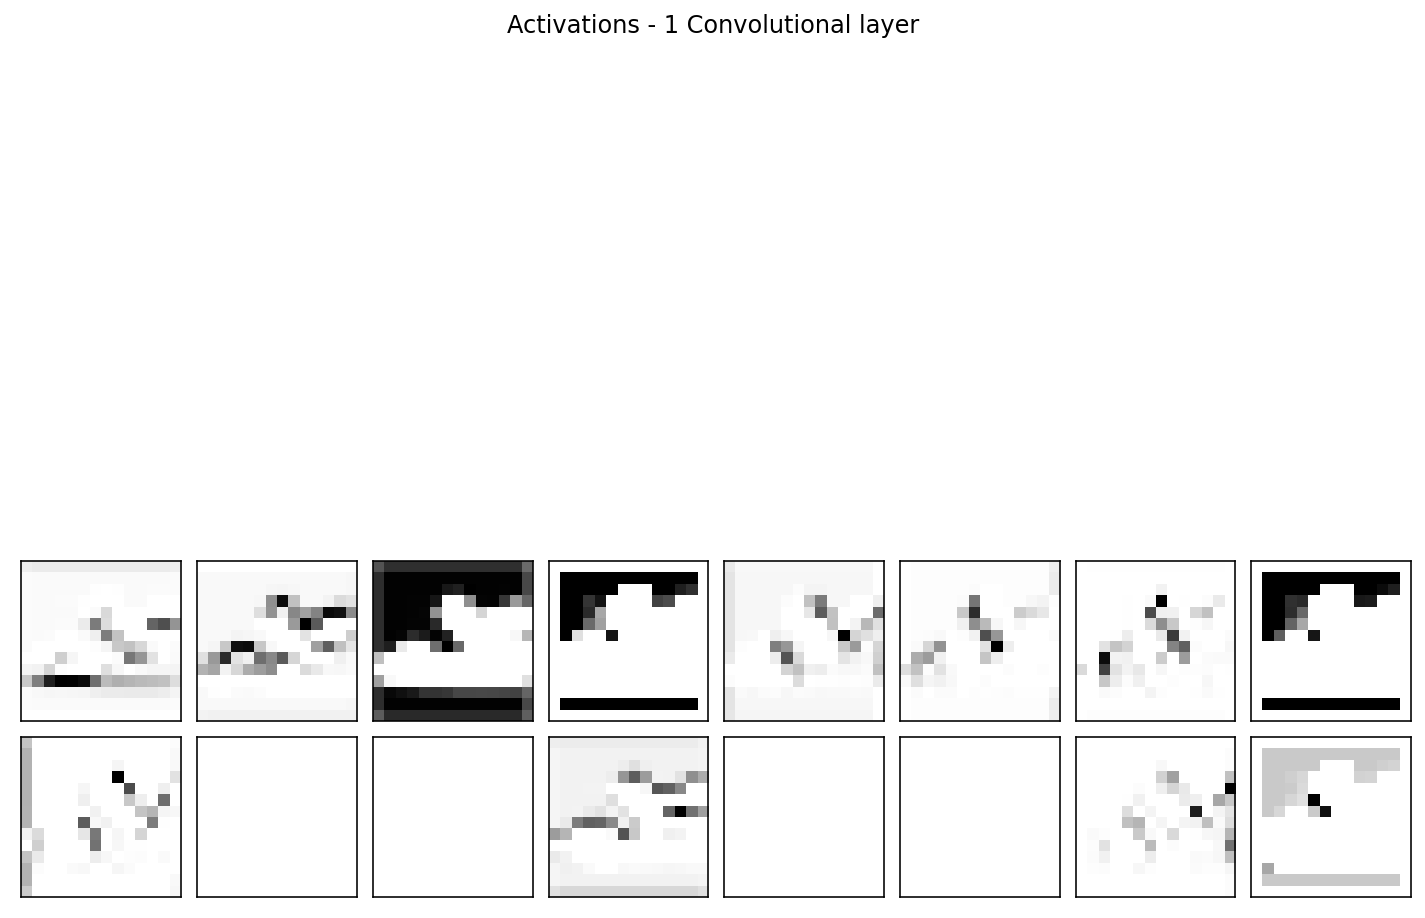

In [44]:
## Plot the activations
fig, ax = plt.subplots(2,8, figsize=(10,10))
for i in range(16):
    ax[i%2, i//2].imshow( first_conv_layer_act[0, i, :, :], cmap='Greys')
    ax[i%2, i//2].set_xticks([])
    ax[i%2, i//2].set_yticks([])
    
    
fig.suptitle('Activations - 1 Convolutional layer', fontsize = 12)    
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=-.85)
plt.savefig('Conv1.png')
plt.show()   

The true label of this sample is: 6


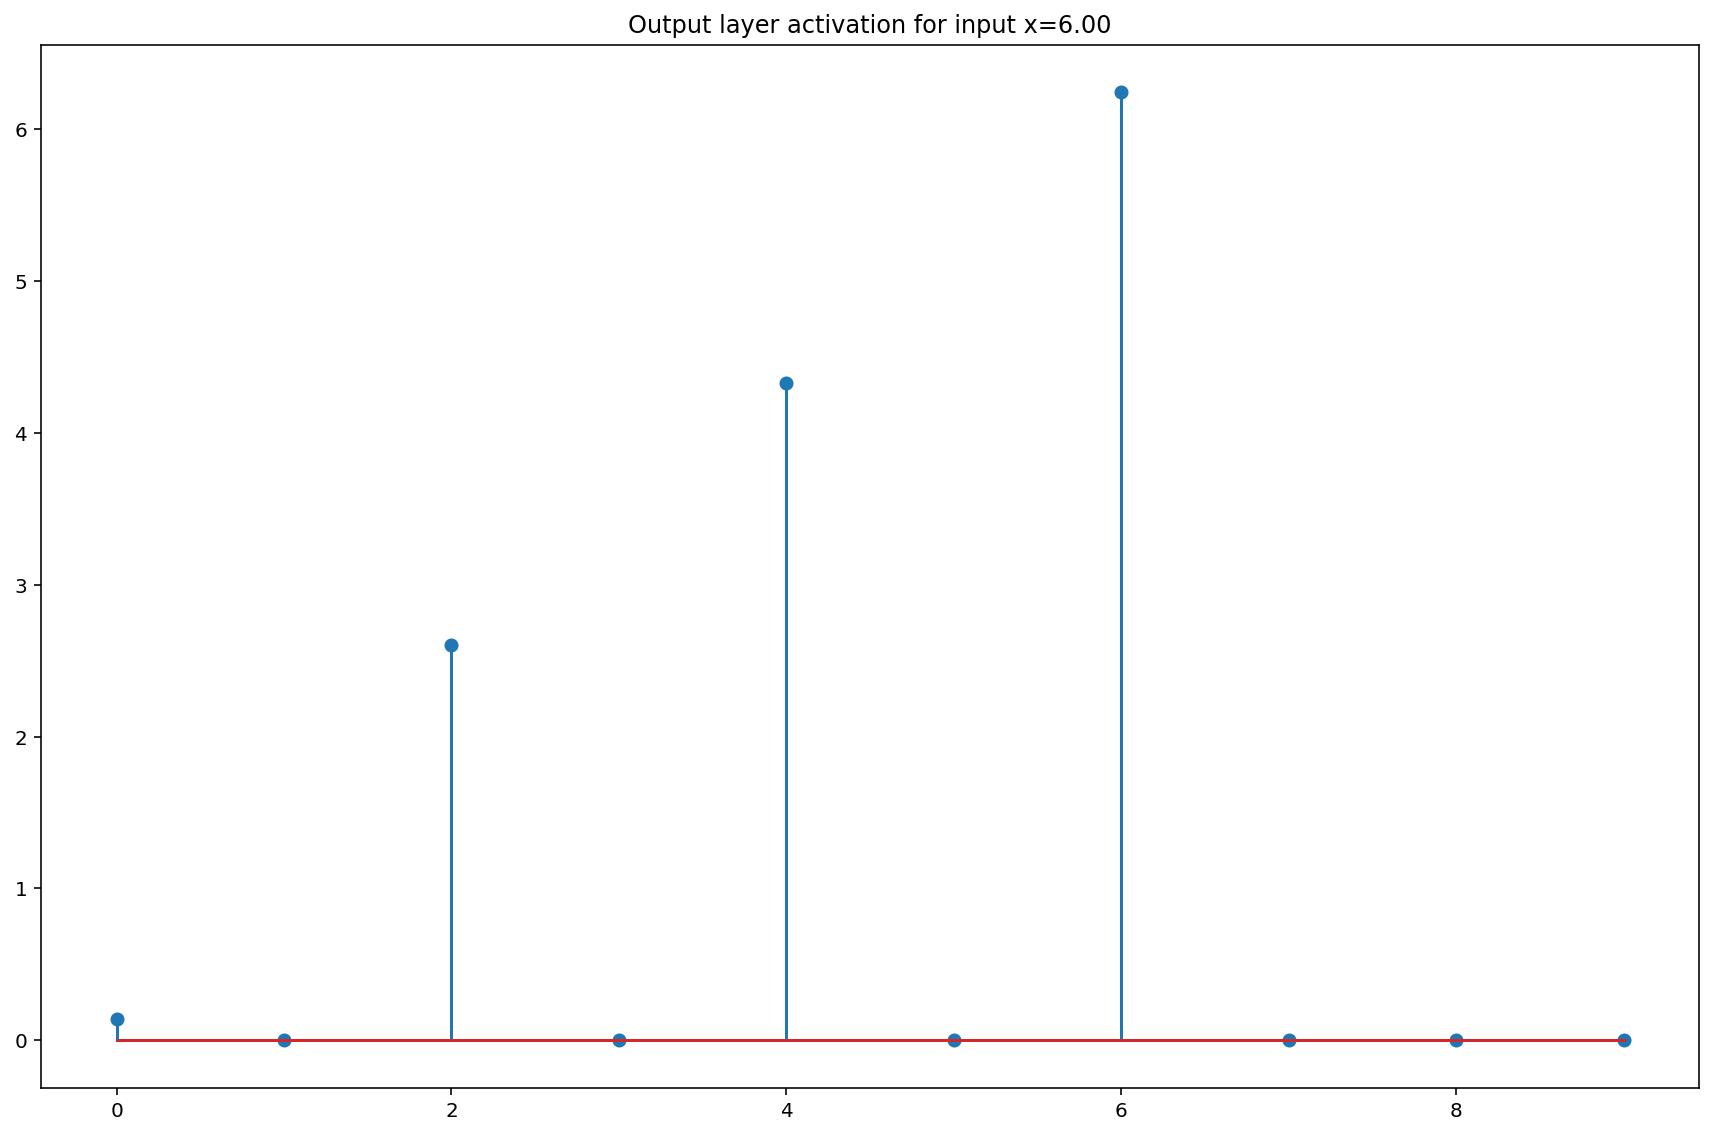

In [46]:
### Register hook  
hook_handle_fin = model.out.register_forward_hook(get_activation)

with torch.no_grad():
    for s_batch in image_test:
        # Move data to device
        x_fin = s_batch[0].to(device)
        # Forward pass
        y_fin = model(x_fin)
        z_fin = activation

print("The true label of this sample is:", int(s_batch[1][0].numpy()))
final_layer_act = z_fin.cpu().numpy()
### Remove hook
hook_handle_fin.remove()



### Plot activations
fig, axs = plt.subplots(1, 1, figsize=(12,8))
axs.stem(final_layer_act[0,:], use_line_collection=True)
axs.set_title('Output layer activation for input x=%.2f' % int(s_batch[1][0].numpy()))

plt.tight_layout()
plt.show()